In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from itertools import product

from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [2]:
chocolate = pd.read_csv('17. monthly-production-of-chocolate.csv', index_col='Month',parse_dates=True)
choco=chocolate['Monthly production of chocolate confectionery in Australia: tonnes. July 1957 ? Aug 1995']
choco

Month
1957-07-01     2953
1957-08-01     2635
1957-09-01     2404
1957-10-01     2413
1957-11-01     2136
              ...  
1995-04-01     6495
1995-05-01     8668
1995-06-01     9685
1995-07-01    10109
1995-08-01    11095
Name: Monthly production of chocolate confectionery in Australia: tonnes. July 1957 ? Aug 1995, Length: 458, dtype: int64

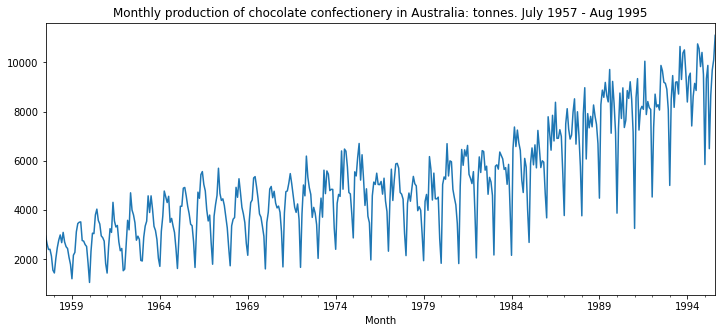

In [3]:
choco.plot(figsize=(12,5))
plt.title('Monthly production of chocolate confectionery in Australia: tonnes. July 1957 - Aug 1995')
plt.show()

In [4]:
transformed, lmbda = boxcox(chocolate['Monthly production of chocolate confectionery in Australia: tonnes. July 1957 ? Aug 1995'])
y_transformation = pd.DataFrame(chocolate['Monthly production of chocolate confectionery in Australia: tonnes. July 1957 ? Aug 1995'].values, columns=['initial'])
y_transformation['transformed'] = transformed
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

In [5]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation['transformed'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.993390
После преобразования Бокса-Кокса: p=0.957237
После сезонного дифференцирования: p=0.000000
После дополнительного дифференцирования: p=0.000000


Тогда можно обойтись без дополнительного дифференцирования, поскольку критерий Дики-Фуллера говорит о том, что после сезонного дифференцирований ряд является стационарным.

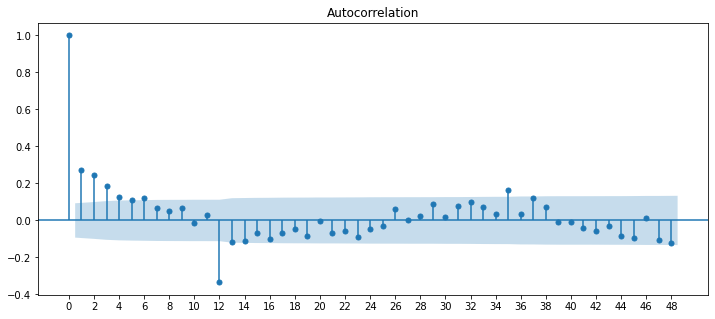

In [6]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(y_transformation['seasonal_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

В качестве начального приближения гиперпараметра 𝑞 берется последний значимый лаг автокорреляции. Последний значимый лаг равен q0=4.

Для сезонного порядка скользящего среднего  𝑄  последним значимым лагом является 12 (один сезонный период). Соответственно, порядок  𝑄0=1.

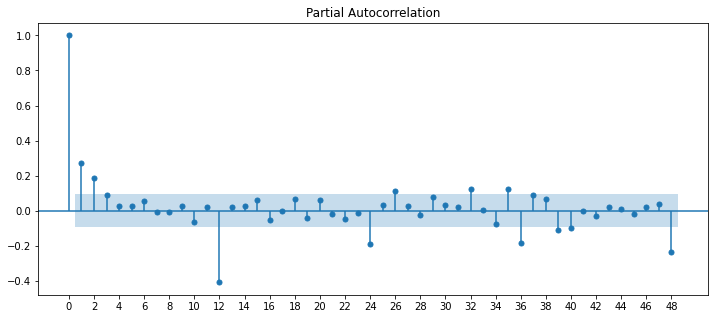

In [7]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(y_transformation['seasonal_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Последний значимый лаг также равен 2, соответственно,  𝑝0=2 . Возьмем  𝑃0=1.

Запустим модель от полученных параметров

In [8]:
model = SARIMAX(y_transformation['seasonal_diff'], 
                order=(2, 0, 4), 
                seasonal_order=(1, 0, 1, 12)).fit()

C:\Users\Nastya\miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
model.aic

2026.5079895920433

In [10]:
model.params

ar.L1       1.085935
ar.L2      -0.088326
ma.L1      -0.800607
ma.L2       0.031120
ma.L3      -0.030351
ma.L4      -0.097884
ar.S.L12    0.151888
ma.S.L12   -0.775039
sigma2      5.186812
dtype: float64

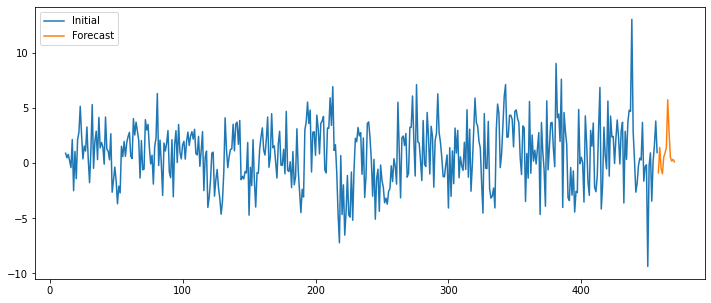

In [11]:
y_transformation['seasonal_diff'].plot(figsize=(12,5))
model.predict(start=y_transformation['seasonal_diff'].size, end=y_transformation['seasonal_diff'].size+12).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

Для выбора оптимальных значений гиперпараметров  𝑝 ,  𝑞 ,  𝑃  и  𝑄  необходимо построить соответствующие модели авторегрессии и оценить их качество. Рассматрим гиперпараметры в окрестности начального приближения  𝑝0 ,  𝑞0 ,  𝑃0 ,  𝑄0 .

In [12]:
p = range(0, 3)
q = range(0, 4)
P = range(0, 3)
Q = range(0, 2)
d = 1

In [13]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

72

In [14]:
list_of_aic=[]
for i in range(len(parameters_list)): #для кажного набора определяем критерий Акаике
    model = SARIMAX(y_transformation['seasonal_diff'], order=(parameters_list[i][0], 0, parameters_list[i][1]),seasonal_order=(parameters_list[i][2], 0,parameters_list[i][3], 12)).fit()
    list_of_aic.append(model.aic)

C:\Users\Nastya\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nastya\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nastya\miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Nastya\miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Nastya\miniconda3\lib\site-packages\statsmodels\

In [15]:
minIndex = list_of_aic.index(min(list_of_aic)) #находим минимальное значение критерия в полученном списке
print(parameters_list[minIndex],list_of_aic[minIndex]) #набор параметров и соответствующее ему мин значение критерия

(2, 2, 1, 1) 2024.6601966970406


In [16]:
model_best = SARIMAX(y_transformation['seasonal_diff'], 
                order=(parameters_list[minIndex][0], 0, parameters_list[minIndex][1]), 
                seasonal_order=(parameters_list[minIndex][2], 0, parameters_list[minIndex][3], 12)).fit()

C:\Users\Nastya\miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
model_best.aic

2024.6601966970406

In [18]:
model_best.params

ar.L1       1.693807
ar.L2      -0.694720
ma.L1      -1.404532
ma.L2       0.433128
ar.S.L12    0.160327
ma.S.L12   -0.765882
sigma2      5.212403
dtype: float64

Сделаем прогноз на год

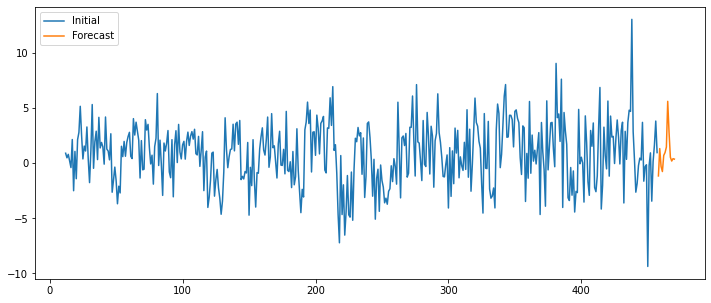

In [19]:
y_transformation['seasonal_diff'].plot(figsize=(12,5))
model_best.predict(start=y_transformation['seasonal_diff'].size, end=y_transformation['seasonal_diff'].size+12).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()